In [168]:
from prelude import *
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from pandas.tseries.offsets import DateOffset
import scipy.stats.distributions as dists
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
conf = SparkConf().setAppName("question4").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
lines = sc.textFile('../data/French/')
lines = lines.map(lambda line: json.loads(line))

In [229]:
# see the 20 most fequent hashtags 

def get_all_hashtags(s):
    hashtags = s['entities']['hashtags']
    res = []
    for hashtag in hashtags:
        res.append((hashtag['text'], 1))
    return res


frequent_hashtags = lines.flatMap(get_all_hashtags).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False).take(20)
for i,v in enumerate(frequent_hashtags):
    if i%4 == 3:
        print('Count of #{:22s}'.format(v[0] + ': ' + str(v[1])))
    else:
        print('Count of #{:22s}'.format(v[0] + ': ' + str(v[1])), end = '')

Count of #Macron: 776           Count of #Mila: 691             Count of #Concours: 671         Count of #coronavirus: 610      
Count of #LREM: 522             Count of #Paris: 469            Count of #GiletsJaunes: 464     Count of #iHeartAwards: 449     
Count of #AsimForTheWin: 404    Count of #ASSEOM: 384           Count of #CONCOURS: 366         Count of #retraites: 352        
Count of #Municipales2020: 347  Count of #Brexit: 330           Count of #FCGBOM: 303           Count of #AsliFans: 285         
Count of #BB13OnVoot: 284       Count of #RT: 273               Count of #PSGMHSC: 270          Count of #SuperBowl: 267        


## Question 4
Task: Anomaly detection in time series.

We implement the simple poisson method, using the count of previous data point as the mean.

In [18]:
'''
alpha: float, confidence level
target_hashtag: string, the hashtag to perform anomaly detection on 
target_eta: float, threshold for anomaly detection
time_interval_x : int, time interval for a single data point to count hashtags
'''

alpha = 0.99
target_hashtag = 'coronavirus'
target_eta = 1
time_interval_day = 0
time_interval_hour = 2
time_interval_minute = 0
time_interval_second = 0

date_time_begin_str = 'Fri Jan 31 23:00:00 +0000 2020'
date_time_end_str = 'Fri Feb 07 23:30:00 +0000 2020'
date_time_pattern = '%a %b %d %H:%M:%S %z %Y'
df_date_time_pattern = '%Y-%m-%d %H:%M:%S'

date_time_begin_obj = datetime.datetime.strptime(
    date_time_begin_str, date_time_pattern)
date_time_end_obj = datetime.datetime.strptime(
    date_time_end_str, date_time_pattern)

delta_time = datetime.timedelta(
     seconds=time_interval_second,
     minutes=time_interval_minute,
     hours=time_interval_hour,
     days=time_interval_day,
     )

In [9]:
# see content of one row
lines.take(1)

[{'created_at': 'Fri Jan 31 22:59:55 +0000 2020',
  'id': 1223380418189299714,
  'id_str': '1223380418189299714',
  'text': "@Yazidinhok ptdrrrrrrrrr je sais que c'est du cinema fast-food mais bon même pas un sur les 150 000 sortis, c'est abusé",
  'display_text_range': [12, 119],
  'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
  'truncated': False,
  'in_reply_to_status_id': 1223379548525531136,
  'in_reply_to_status_id_str': '1223379548525531136',
  'in_reply_to_user_id': 3435541767,
  'in_reply_to_user_id_str': '3435541767',
  'in_reply_to_screen_name': 'Yazidinhok',
  'user': {'id': 1039569053428469760,
   'id_str': '1039569053428469760',
   'name': 'Walid.',
   'screen_name': 'walid_srh',
   'location': 'Paris, France',
   'url': 'https://twitter.com/warriors/status/741477884888391681?s=21',
   'description': '| W.Y | ceux qui manquent sont déjà partis | T.C.O',
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'fo

In [8]:
def get_time_period(t, time_bucket_size, time_start_at):
    '''
    Convert a time point to its belonging time period. The time periods start at time_start_at, with size of time_bucket_size
    input:
        t: string, time point
        time_bucket_size: datetiem.timedelta
        time_start_at: datetime.datetime
    
    return:
        date_time_time_period_str: string, the time period the tweet created at
    '''
    curr_datetime = datetime.datetime.strptime(
        t, date_time_pattern)
    date_time_time_period = ((curr_datetime - time_start_at)//time_bucket_size) * time_bucket_size + time_start_at
    date_time_time_period_str = date_time_time_period.strftime(df_date_time_pattern)
    return date_time_time_period_str


def get_time_period_for_row(s, time_bucket_size, time_start_at):
    '''
    Assign the created time period to a tweet. The time periods start at time_start_at, with size of time_bucket_size
    input:
        s: row in RDD
        time_bucket_size: datetiem.timedelta
        time_start_at: datetime.datetime
    
    return:
        date_time_time_period_str: string, the time period the tweet created at
        (date_time_time_period_str, 1)
    '''
    date_time_time_period_str = get_time_period(s['created_at'], time_bucket_size, time_start_at)
    s['created_at_time_period'] = date_time_time_period_str
    return s
    
    
def filter_hashtag(s, target_hashtag):
    '''
    Filter the tweet who contains target_hashtag
    '''
    hashtags = list(map(lambda h: h['text'], s['entities']['hashtags']))
    return target_hashtag in hashtags

In [9]:
# filter the tweet with target hashtag
tweet_with_hashtag = lines.filter(lambda s: filter_hashtag(s, target_hashtag)).map(lambda s: get_time_period_for_row(s, delta_time, date_time_begin_obj))
# get the count of tweet with target hashtag within a time inteval
hashtag_trend = tweet_with_hashtag.map(lambda s: (s['created_at_time_period'], 1)).reduceByKey(lambda a, b: a + b)
# convert the result into pandas(the size is already small enough)
hashtag_trend_df = spark.createDataFrame(hashtag_trend,schema=['t', 'hashtag_count']).toPandas()

In [10]:
# convert the format of t
hashtag_trend_df['t'] = pd.to_datetime(hashtag_trend_df['t']).dt.strftime(df_date_time_pattern)
hashtag_trend_df = hashtag_trend_df.set_index('t')

# Create dataframe with full time intervals index 
#(at some time intervals, the tweet count is 0, so no row in hashtag_trend_df to represent this time interval) 
time_index = pd.date_range(start=date_time_begin_obj, end=date_time_end_obj, freq = delta_time, name='t').strftime(df_date_time_pattern)
full_time_index_df = pd.DataFrame(index = time_index)

# Fill in the hashtag_trend_df with full time intervals index 
hashtag_trend_df = full_time_index_df.join(hashtag_trend_df).fillna(0).reset_index()

In [11]:
hashtag_trend_df

,t,hashtag_count
0,2020-01-31 23:00:00,14.0
1,2020-02-01 01:00:00,3.0
2,2020-02-01 03:00:00,0.0
3,2020-02-01 05:00:00,8.0
4,2020-02-01 07:00:00,9.0
...,...,...
80,2020-02-07 15:00:00,11.0
81,2020-02-07 17:00:00,13.0
82,2020-02-07 19:00:00,10.0
83,2020-02-07 21:00:00,6.0


In [25]:
def get_eta(row, alpha):
    
    # use simple poisson model, mean = count of the previous point
    # inspired by the code https://github.com/twitterdev/Gnip-Trend-Detection/blob/master/gnip_trend_detection/models.py
    
    index = row.name
    if index == 0:
        return 0
    else:
        last_count = hashtag_trend_df.loc[index-1].hashtag_count
        
    current_count = row.hashtag_count

    if last_count == 0 or current_count == 0:
        return 0

    Delta_r = abs(current_count - last_count) 
    sensitivity = float(Delta_r)/last_count 
    delta_r = dists.poisson.interval(alpha,last_count)[1] - dists.poisson.interval(alpha,last_count)[0]
    relative_confidence_interval = delta_r/last_count
    return sensitivity/relative_confidence_interval



In [64]:
# Calculate eta for each data point
hashtag_trend_df['eta1 (alpha = 0.99)'] = 0.
hashtag_trend_df['eta2 (alpha = 0.60)'] = 0.
hashtag_trend_df['eta3 (alpha = 0.30)'] = 0.
hashtag_trend_df['eta1 (alpha = 0.99)'] = hashtag_trend_df.apply(lambda x: get_eta(x, alpha = 0.99), axis=1)
hashtag_trend_df['eta2 (alpha = 0.60)'] = hashtag_trend_df.apply(lambda x: get_eta(x, alpha = 0.6), axis=1)
hashtag_trend_df['eta3 (alpha = 0.30)'] = hashtag_trend_df.apply(lambda x: get_eta(x, alpha = 0.3), axis=1)
hashtag_trend_df = hashtag_trend_df.set_index('t')
hashtag_trend_df

,hashtag_count,eta1 (alpha = 0.99),eta2 (alpha = 0.60),eta3 (alpha = 0.30)
t,,,,
2020-01-31 23:00:00,14.0,0.000000,0.000000,0.000000
2020-02-01 01:00:00,3.0,0.550000,1.833333,3.666667
2020-02-01 03:00:00,0.0,0.000000,0.000000,0.000000
2020-02-01 05:00:00,8.0,0.000000,0.000000,0.000000
2020-02-01 07:00:00,9.0,0.071429,0.250000,0.500000
...,...,...,...,...
2020-02-07 15:00:00,11.0,0.000000,0.000000,0.000000
2020-02-07 17:00:00,13.0,0.125000,0.333333,1.000000
2020-02-07 19:00:00,10.0,0.166667,0.500000,1.000000


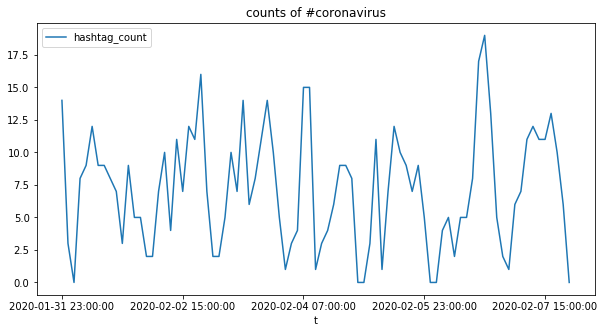

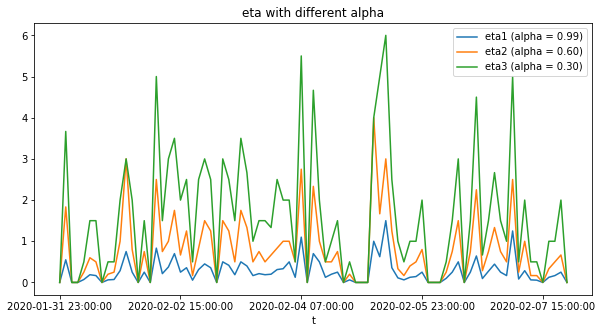

In [70]:
# draw the plot
axes1 = hashtag_trend_df[['hashtag_count']].plot.line(
    title = 'counts of #' + target_hashtag, 
    figsize = (10,5),
    
)
axes2 = hashtag_trend_df[['eta1 (alpha = 0.99)','eta2 (alpha = 0.60)','eta3 (alpha = 0.30)']].plot.line(
    title = 'eta with different alpha', 
    figsize = (10,5)
)

In [88]:
pd.date_range(start=date_time_begin_obj, end=date_time_end_obj, periods = 10, name='t').strftime(df_date_time_pattern)

Index(['2020-01-31 23:00:00', '2020-02-01 17:43:20', '2020-02-02 12:26:40',
       '2020-02-03 07:10:00', '2020-02-04 01:53:20', '2020-02-04 20:36:40',
       '2020-02-05 15:20:00', '2020-02-06 10:03:20', '2020-02-07 04:46:40',
       '2020-02-07 23:30:00'],
      dtype='object', name='t')

Text(0.5, 0, '')

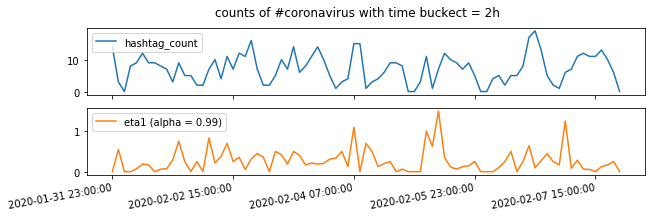

In [141]:
axes1 = hashtag_trend_df[['hashtag_count','eta1 (alpha = 0.99)']].plot.line(
    subplots = True,
    title = 'counts of #{} with time buckect = {}h'.format(target_hashtag, time_interval_hour), 
    figsize = (10,3),
)
axes1[1].tick_params(axis='x', rotation=10)
axes1[1].set_xlabel(None)

In [115]:
# Show the data point with anomalies
event_intervals = hashtag_trend_df[hashtag_trend_df['eta1 (alpha = 0.99)'] > target_eta].index.tolist()
print('detected events:', event_intervals)

detected events: ['2020-02-04 07:00:00', '2020-02-05 11:00:00', '2020-02-07 05:00:00']


We sort the data by eta calculated by differet alpha.

In [80]:
hashtag_trend_df.sort_values('eta1 (alpha = 0.99)', ascending = False)[:5]

,hashtag_count,eta1 (alpha = 0.99),eta2 (alpha = 0.60),eta3 (alpha = 0.30)
t,,,,
2020-02-05 11:00:00,7.0,1.500000,3.00,6.0
2020-02-07 05:00:00,6.0,1.250000,2.50,5.0
2020-02-04 07:00:00,15.0,1.100000,2.75,5.5
2020-02-05 07:00:00,11.0,1.000000,4.00,4.0
2020-02-02 07:00:00,7.0,0.833333,2.50,5.0


In [81]:
hashtag_trend_df.sort_values('eta2 (alpha = 0.60)', ascending = False)[:5]

,hashtag_count,eta1 (alpha = 0.99),eta2 (alpha = 0.60),eta3 (alpha = 0.30)
t,,,,
2020-02-05 07:00:00,11.0,1.00,4.00,4.0
2020-02-01 21:00:00,9.0,0.75,3.00,3.0
2020-02-05 11:00:00,7.0,1.50,3.00,6.0
2020-02-04 07:00:00,15.0,1.10,2.75,5.5
2020-02-07 05:00:00,6.0,1.25,2.50,5.0


In [82]:
hashtag_trend_df.sort_values('eta3 (alpha = 0.30)', ascending = False)[:5]

,hashtag_count,eta1 (alpha = 0.99),eta2 (alpha = 0.60),eta3 (alpha = 0.30)
t,,,,
2020-02-05 11:00:00,7.0,1.500000,3.000000,6.0
2020-02-04 07:00:00,15.0,1.100000,2.750000,5.5
2020-02-02 07:00:00,7.0,0.833333,2.500000,5.0
2020-02-05 09:00:00,1.0,0.625000,1.666667,5.0
2020-02-07 05:00:00,6.0,1.250000,2.500000,5.0


Redo the detection with different time bucket.

Anomaly detection with time bucket = 2h


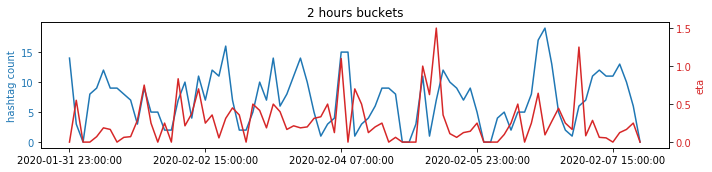

detected events: ['2020-02-04 07:00:00', '2020-02-05 11:00:00', '2020-02-07 05:00:00']
Anomaly detection with time bucket = 4h


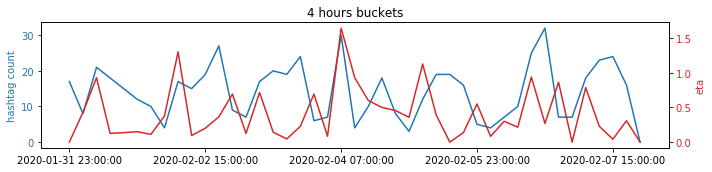

detected events: ['2020-02-02 07:00:00', '2020-02-04 07:00:00', '2020-02-05 07:00:00']
Anomaly detection with time bucket = 8h


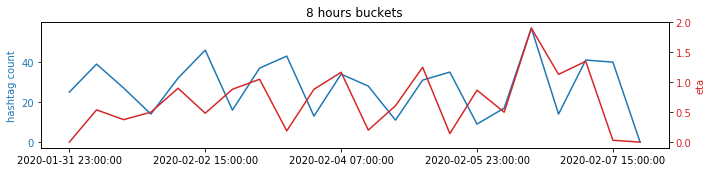

detected events: ['2020-02-03 07:00:00', '2020-02-04 07:00:00', '2020-02-05 07:00:00', '2020-02-06 15:00:00', '2020-02-06 23:00:00', '2020-02-07 07:00:00']


In [197]:
time_interval_hours = [2, 4, 8]
for time_interval_hour in time_interval_hours:
    print('Anomaly detection with time bucket = {}h'.format(time_interval_hour))
    delta_time = datetime.timedelta(
     seconds=time_interval_second,
     minutes=time_interval_minute,
     hours=time_interval_hour,
     days=time_interval_day,
     )
    
    # filter the tweet with target hashtag
    tweet_with_hashtag = lines.filter(lambda s: filter_hashtag(s, target_hashtag)).map(lambda s: get_time_period_for_row(s, delta_time, date_time_begin_obj))
    # get the count of tweet with target hashtag within a time inteval
    hashtag_trend = tweet_with_hashtag.map(lambda s: (s['created_at_time_period'], 1)).reduceByKey(lambda a, b: a + b)
    # convert the result into pandas(the size is already small enough)
    hashtag_trend_df = spark.createDataFrame(hashtag_trend,schema=['t', 'hashtag_count']).toPandas()
    
    # convert the format of t
    hashtag_trend_df['t'] = pd.to_datetime(hashtag_trend_df['t']).dt.strftime(df_date_time_pattern)
    hashtag_trend_df = hashtag_trend_df.set_index('t')

    # Create dataframe with full time intervals index 
    #(at some time intervals, the tweet count is 0, so no row in hashtag_trend_df to represent this time interval) 
    time_index = pd.date_range(start=date_time_begin_obj, end=date_time_end_obj, freq = delta_time, name='t').strftime(df_date_time_pattern)
    full_time_index_df = pd.DataFrame(index = time_index)

    # Fill in the hashtag_trend_df with full time intervals index 
    hashtag_trend_df = full_time_index_df.join(hashtag_trend_df).fillna(0).reset_index()
    
    hashtag_trend_df['eta1 (alpha = 0.99)'] = 0.
    hashtag_trend_df['eta1 (alpha = 0.99)'] = hashtag_trend_df.apply(lambda x: get_eta(x, alpha = 0.99), axis=1)
    hashtag_trend_df = hashtag_trend_df.set_index('t')
    
    fig, ax1 = plt.subplots(figsize = (10,2.5))

    ax1.set_title('{} hours buckets'.format(time_interval_hour))

    color = 'tab:blue'
    ax1.set_xlabel(None)
    ax1.set_ylabel('hashtag count', color=color)
    ax1.plot(hashtag_trend_df[['hashtag_count']], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('eta', color=color)  # we already handled the x-label with ax1
    ax2.plot(hashtag_trend_df[['eta1 (alpha = 0.99)']], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(5))

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
    event_intervals = hashtag_trend_df[hashtag_trend_df['eta1 (alpha = 0.99)'] > target_eta].index.tolist()
    print('detected events:', event_intervals)